In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table

In [117]:
# Read the table
t1 = Table.read('TgasxWrightx2mass.vot',format='votable')
print(t1.colnames)
Jmags = t1["Jmag"]
Hmags = t1["Hmag"]
Kmags = t1["Kmag"]
QFlags = t1["Qfl"]
Qascii = str(QFlags,'utf-8')
RFlags = t1["Rfl"]

print(type(Qascii[0]))

for i in range(0,10):
    print(i,Qascii[i])
    if(Qascii[i][0] == 'A'):
        print(i,Qascii[i])

print(QFlags[0:10])

['d_arcsec', 'd_arcsec_2', '_RAJ2000', '_DEJ2000', 'HIP', 'TYC2', 'Source', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', 'TYC1', 'TYC2_2', 'TYC3', 'RAJ2000', 'DEJ2000', 'VTmag', 'BTmag', 'r_SpType', 'Dist', 'Mag', 'Teff', 'SpType', '_2MASS', 'RAJ2000_2', 'DEJ2000_2', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb8 in position 1: invalid start byte

['d_arcsec', 'd_arcsec_2', '_RAJ2000', '_DEJ2000', 'HIP', 'TYC2', 'Source', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', 'TYC1', 'TYC2_2', 'TYC3', 'RAJ2000', 'DEJ2000', 'VTmag', 'BTmag', 'r_SpType', 'Dist', 'Mag', 'Teff', 'SpType', '_2MASS', 'RAJ2000_2', 'DEJ2000_2', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']
   Dist   
   arcs   
----------
0.38800001
     1.517
0.97600001
     0.398
     0.477
     0.245
0.59500003
      1.51
0.49700001
     1.171
       ...
     0.352
0.45500001
     0.329
     0.113
0.77200001
     0.154
0.33700001
     0.287
 1.0319999
     0.396
Length = 28815 rows


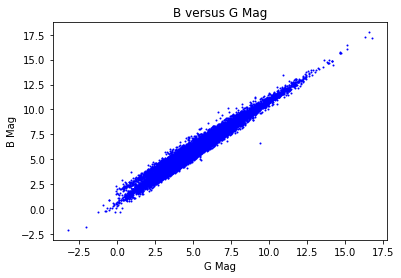

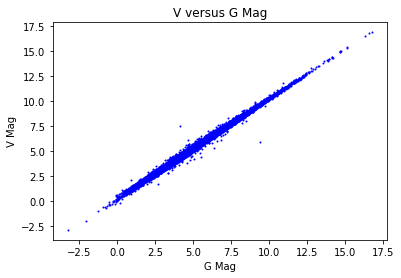

[3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


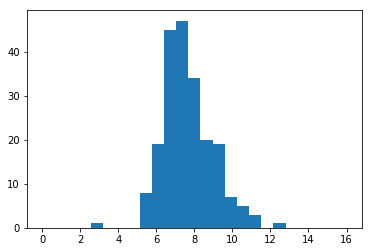

Number of stars in Teff= 3500 - 3999 : 209
     Median value:  7.66688
     Variance:      1.33346


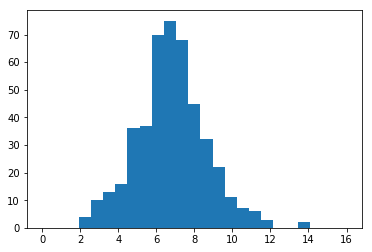

Number of stars in Teff= 4000 - 4499 : 457
     Median value:  6.81424
     Variance:      1.8306


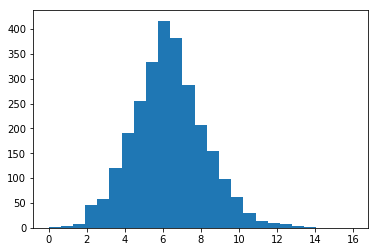

Number of stars in Teff= 4500 - 4999 : 2691
     Median value:  6.33135
     Variance:      1.90336


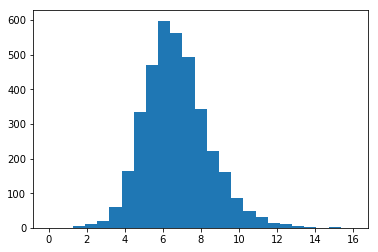

Number of stars in Teff= 5000 - 5499 : 3647
     Median value:  6.72132
     Variance:      1.71226


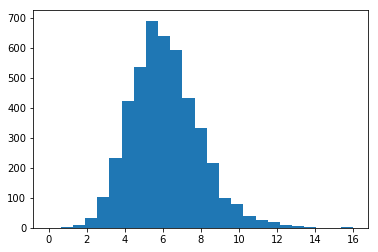

Number of stars in Teff= 5500 - 5999 : 4530
     Median value:  6.13963
     Variance:      1.81446


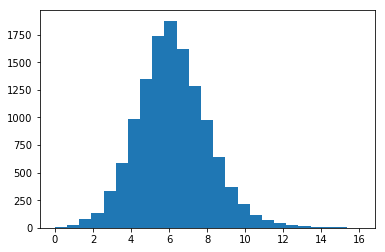

Number of stars in Teff= 6000 - 6499 : 12494
     Median value:  6.19295
     Variance:      1.87245


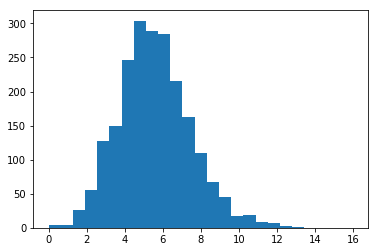

Number of stars in Teff= 6500 - 6999 : 2147
     Median value:  5.57435
     Variance:      1.89846


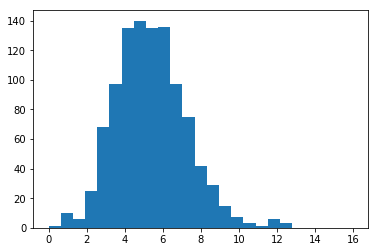

Number of stars in Teff= 7000 - 7499 : 1032
     Median value:  5.3847
     Variance:      1.8567


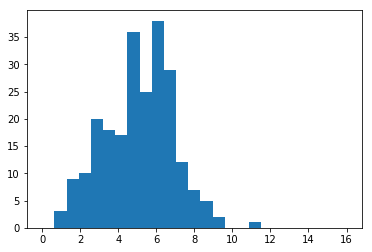

Number of stars in Teff= 7500 - 7999 : 232
     Median value:  5.09957
     Variance:      1.81417


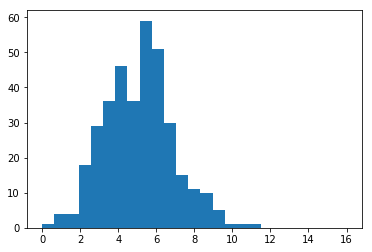

Number of stars in Teff= 8000 - 8499 : 359
     Median value:  5.03884
     Variance:      1.81824


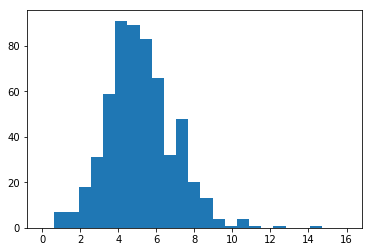

Number of stars in Teff= 8500 - 8999 : 577
     Median value:  5.20385
     Variance:      1.84166


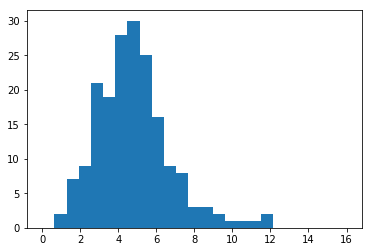

Number of stars in Teff= 9000 - 9499 : 188
     Median value:  4.77534
     Variance:      1.97626


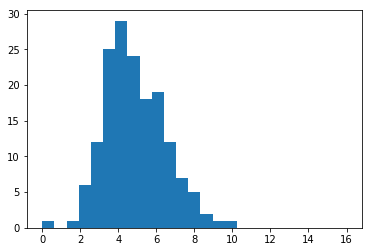

Number of stars in Teff= 9500 - 9999 : 163
     Median value:  4.89932
     Variance:      1.59004


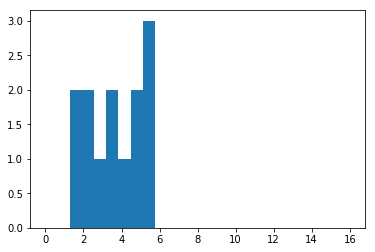

Number of stars in Teff= 10000 - 10499 : 13
     Median value:  3.72831
     Variance:      1.43001


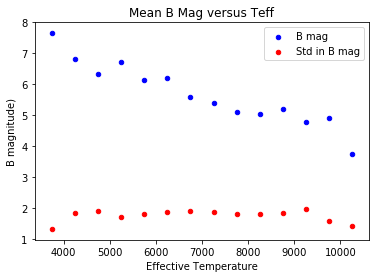

In [21]:
Teff = t1["Teff"]
Dist  = t1["Dist"]
Bmags = t1["BTmag"] - 5 - 5*np.log10(Dist)
Vmags = t1["VTmag"] - 5 - 5*np.log10(Dist)
Gmags = t1["__Gmag_"] - 5 - 5*np.log10(Dist)
Jmags = t1["Jmag"]
Hmags = t1["Hmag"]
Kmags = t1["Kmag"]

plt.title("B versus G Mag")
plt.xlabel('G Mag')
plt.ylabel('B Mag')
plt.scatter(Gmags,Bmags,color='b',s=1.0)
plt.show()

plt.title("V versus G Mag")
plt.xlabel('G Mag')
plt.ylabel('V Mag')
plt.scatter(Gmags,Vmags,color='b',s=1.0)
plt.show()

temps = [3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]
print(temps)
Tave = []
Bmean = []
Bstd = []

for tlow in temps:
    thi = tlow + 499.
    tmean = (thi+tlow)/2.0
    TeffMask = ma.masked_outside(Teff,tlow,thi)
    BMask = ma.array(Bmags,mask=TeffMask.mask)
    Bplt = ma.compressed(BMask)
    plt.hist(Bplt,bins=25,range=(0,16))
    plt.show()
    Tave.append(tmean)
    Bmean.append(np.mean(Bplt))
    Bstd.append(np.std(Bplt))
    print("Number of stars in Teff= %g - %g :"%(tlow,thi), TeffMask.count())
    print("     Median value: ", np.mean(Bplt))
    print("     Variance:     ",np.std(Bplt))

plt.title("Mean B Mag versus Teff")
plt.xlabel('Effective Temperature')
plt.ylabel('B magnitude)')
pllab1 = plt.scatter(Tave,Bmean,s=20,c='b', label='plt1')
pllab2 = plt.scatter(Tave,Bstd,s=20,c='r', label='plt2')
plt.legend([pllab1,pllab2],['B mag','Std in B mag'])
plt.show()

In [4]:
# Read the table
t2 = Table.read('tgas125xwright.vot',format='votable')


In [5]:
print(t2.colnames)

['d_arcsec', '_RAJ2000', '_DEJ2000', 'HIP', 'TYC2', 'Source', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', 'TYC1', 'TYC2_2', 'TYC3', 'RAJ2000', 'DEJ2000', 'VTmag', 'BTmag', 'r_SpType', 'Dist', 'Mag', 'Teff', 'SpType']


In [7]:
Teff = t2["Teff"]
plt.title("Histogram of Teff")
plt.xlabel('Teff bins')
plt.ylabel('Number of stars in bin')
plt.hist(Teff,bins=30,color='b')
plt.show()

plt.title("Histogram of Teff")
plt.xlabel('Teff bins')
plt.ylabel('Number of stars in bin')
plt.hist(Teff,bins=45,range=(2000,12000),color='b')
plt.show()

print("Results of number of stars in low Teff bins for TGAS x Wright et al Catalog")
TeffMask = ma.masked_outside(Teff,2000,2500)
print("   Number of stars between 2000 and 2500: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,2501,3000)
print("   Number of stars between 2501 and 3000: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,3001,3500)
print("   Number of stars between 3001 and 3500: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,3501,4000)
print("   Number of stars between 3500 and 4000: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,4001,4500)
print("   Number of stars between 4001 and 4500: ", TeffMask.count())

NameError: name 't2' is not defined

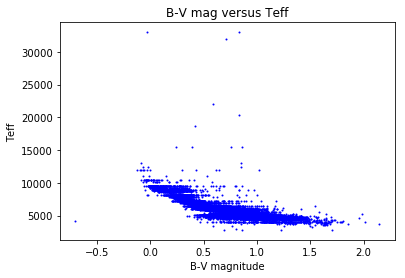

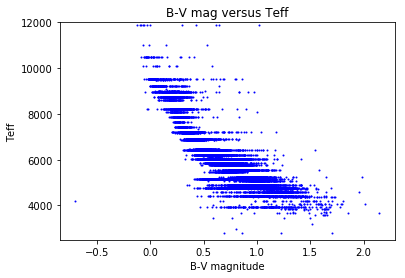

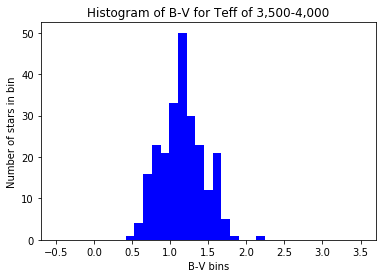

Number of stars in Teff=3,500-4,000: 241
     Median value:  1.16004
     Variance:      0.285972


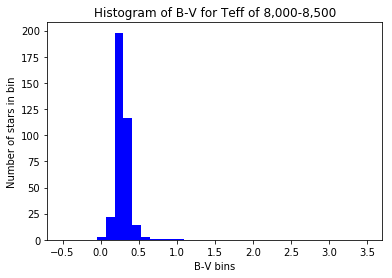

Number of stars in Teff=8,000-8,500: 360
     Median value:  0.283161
     Variance:      0.101145
[2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000]
Number of stars in Teff= 2500 - 2999 : 5
     Median value:  1.0554
     Variance:      0.368924
Number of stars in Teff= 3000 - 3499 : 5
     Median value:  1.1244
     Variance:      0.380902
Number of stars in Teff= 3500 - 3999 : 234
     Median value:  1.15772
     Variance:      0.282588
Number of stars in Teff= 4000 - 4499 : 501
     Median value:  1.14551
     Variance:      0.266066
Number of stars in Teff= 4500 - 4999 : 2880
     Median value:  0.997642
     Variance:      0.190006
Number of stars in Teff= 5000 - 5499 : 3780
     Median value:  0.810099
     Variance:      0.147398
Number of stars in Teff= 5500 - 5999 : 4931
     Median value:  0.74942
     Variance:      0.0964396
Number of stars in Teff= 6000 - 6499 : 12708
     Median value:  0.593711
 

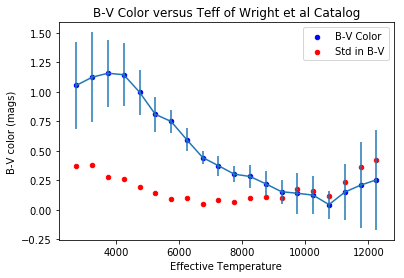

In [7]:
Teff = t2["Teff"]
Bmags = t2["BTmag"]
Vmags = t2["VTmag"]
BmV = Bmags - Vmags
plt.title("B-V mag versus Teff")
plt.xlabel('B-V magnitude')
plt.ylabel('Teff')
plt.scatter(BmV,Teff,color='b',s=1.0)
plt.show()

plt.title("B-V mag versus Teff")
plt.xlabel('B-V magnitude')
plt.ylabel('Teff')
plt.ylim(2500,12000)
plt.scatter(BmV,Teff,color='b',s=1.0)
plt.show()

TeffMask = ma.masked_outside(Teff,3500,4000)
BmVMask = ma.array(BmV,mask=TeffMask.mask)
BmVplt = BmVMask.compressed()
plt.title("Histogram of B-V for Teff of 3,500-4,000")
plt.xlabel('B-V bins')
plt.ylabel('Number of stars in bin')
plt.hist(BmVplt,bins=35,range=(-0.5,3.5),color='b')
plt.show()
print("Number of stars in Teff=3,500-4,000:", TeffMask.count())
print("     Median value: ", np.mean(BmVplt))
print("     Variance:     ",np.std(BmVplt))

TeffMask = ma.masked_outside(Teff,8000,8500)
BmVMask = ma.array(BmV,mask=TeffMask.mask)
BmVplt = BmVMask.compressed()
plt.title("Histogram of B-V for Teff of 8,000-8,500")
plt.xlabel('B-V bins')
plt.ylabel('Number of stars in bin')
plt.hist(BmVplt,bins=35,range=(-0.5,3.5),color='b')
plt.show()
print("Number of stars in Teff=8,000-8,500:", TeffMask.count())
print("     Median value: ", np.mean(BmVplt))
print("     Variance:     ",np.std(BmVplt))

temps = [2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000]
print(temps)
Tave = []
BmVave = []
BmVstd = []
for tlow in temps:
    thi = tlow + 499.
    tmean = (thi+tlow)/2.0
    TeffMask = ma.masked_outside(Teff,tlow,thi)
    BmVMask = ma.array(BmV,mask=TeffMask.mask)
    BmVplt = BmVMask.compressed()
    Tave.append(tmean)
    BmVave.append(np.mean(BmVplt))
    BmVstd.append(np.std(BmVplt))
    print("Number of stars in Teff= %g - %g :"%(tlow,thi), TeffMask.count())
    print("     Median value: ", np.mean(BmVplt))
    print("     Variance:     ",np.std(BmVplt))
print(Tave)
print(BmVave)

plt.title("B-V Color versus Teff of Wright et al Catalog")
plt.xlabel('Effective Temperature')
plt.ylabel('B-V color (mags)')
pllab1 = plt.scatter(Tave,BmVave,s=20,c='b', label='plt1')
pllab2 = plt.scatter(Tave,BmVstd,s=20,c='r', label='plt2')
plt.legend([pllab1,pllab2],['B-V Color','Std in B-V'])
plt.errorbar(Tave,BmVave,yerr=BmVstd)
plt.show()


140519581833816
6440
140519632631288
6440
--
6440
6440
12880
6440


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [59]:
len(b)

28815